# Load Dataset and Library

In [29]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import re

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [2]:
df = pd.read_csv('data-trace.csv')

In [3]:
df.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,172.217.194.95,10.10.1.198,TCP,96,443 > 59620 [ACK] Seq=1 Ack=1 Win=15371 Len=...
1,2,0.000000,172.217.194.95,10.10.1.198,TCP,96,[TCP Dup ACK 1#1] 443 > 59620 [ACK] Seq=1 Ac...
2,3,0.000000,172.217.194.95,10.10.1.198,TCP,96,[TCP Dup ACK 1#2] 443 > 59620 [ACK] Seq=1 Ac...
3,4,0.000101,172.217.194.95,10.10.1.198,TCP,96,443 > 59620 [ACK] Seq=1 Ack=1401 Win=15371 L...
4,5,0.000101,172.217.194.95,10.10.1.198,TCP,96,[TCP Dup ACK 4#1] 443 > 59620 [ACK] Seq=1 Ac...


# EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250688 entries, 0 to 250687
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   No.          250688 non-null  int64  
 1   Time         250688 non-null  float64
 2   Source       250688 non-null  object 
 3   Destination  250279 non-null  object 
 4   Protocol     250688 non-null  object 
 5   Length       250688 non-null  int64  
 6   Info         250688 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 13.4+ MB


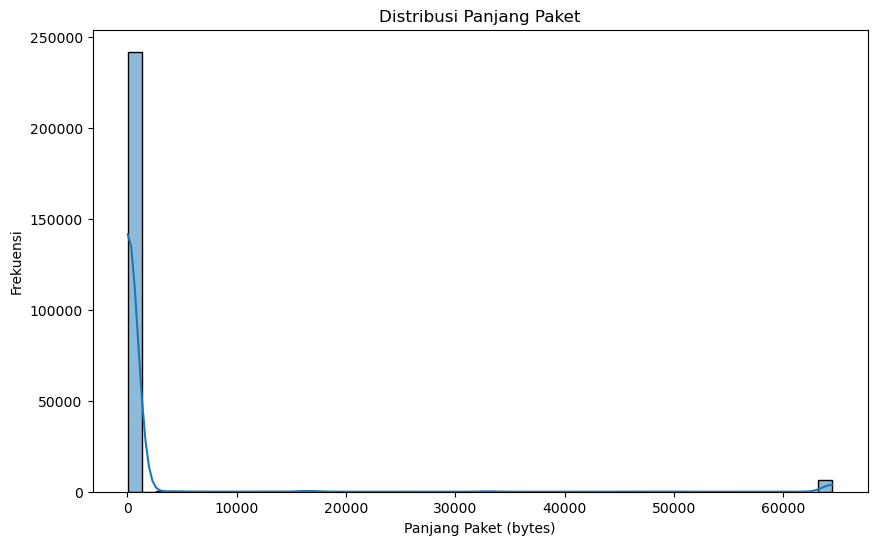

In [5]:
# Visualisasi distribusi panjang paket dengan histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['Length'], bins=50, kde=True)
plt.title('Distribusi Panjang Paket')
plt.xlabel('Panjang Paket (bytes)')
plt.ylabel('Frekuensi')
plt.show()

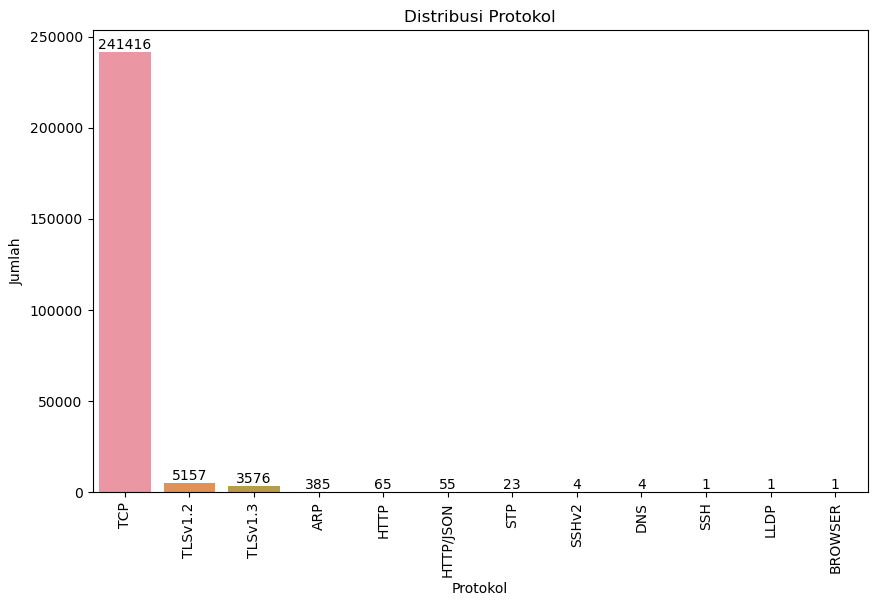

In [6]:

# Contoh visualisasi distribusi protokol dengan jumlah di tiap bar
plt.figure(figsize=(10, 6))
protocol_counts = df['Protocol'].value_counts()
sns.barplot(x=protocol_counts.index, y=protocol_counts.values)
plt.title('Distribusi Protokol')
plt.xlabel('Protokol')
plt.ylabel('Jumlah')
# Tambahkan jumlah di atas tiap bar
for index, value in enumerate(protocol_counts.values):
    plt.text(index, value, str(value), ha='center', va='bottom')
plt.xticks(rotation=90)
plt.show()


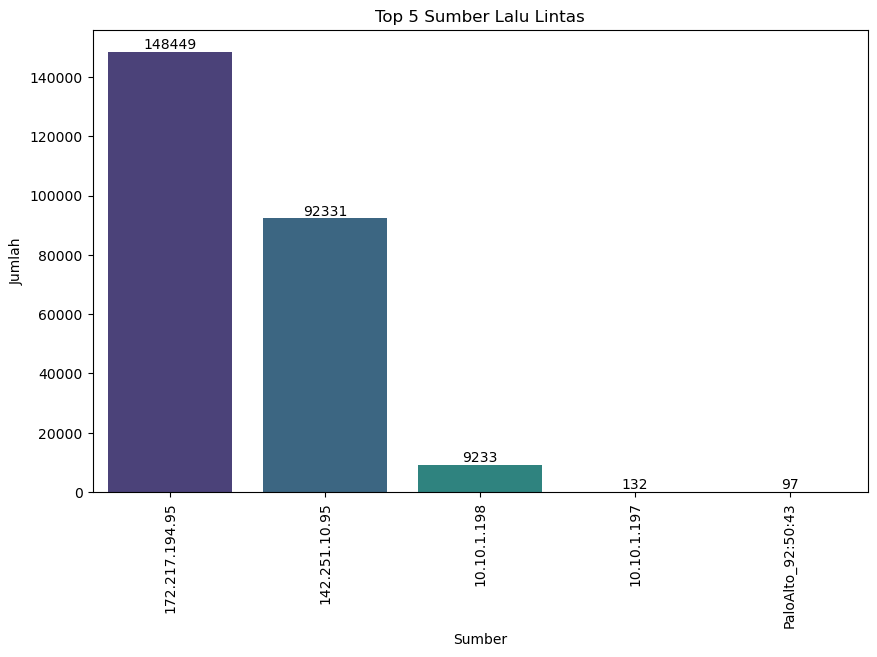

In [7]:
# Visualisasi top 5 sumber dengan bar plot
top_sources = df['Source'].value_counts().head(5)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_sources.index, y=top_sources.values, palette='viridis')
plt.title('Top 5 Sumber Lalu Lintas')
plt.xlabel('Sumber')
plt.ylabel('Jumlah')
# Tambahkan jumlah di atas tiap bar
for index, value in enumerate(top_sources.values):
    plt.text(index, value, str(value), ha='center', va='bottom')
plt.xticks(rotation=90)
plt.show()

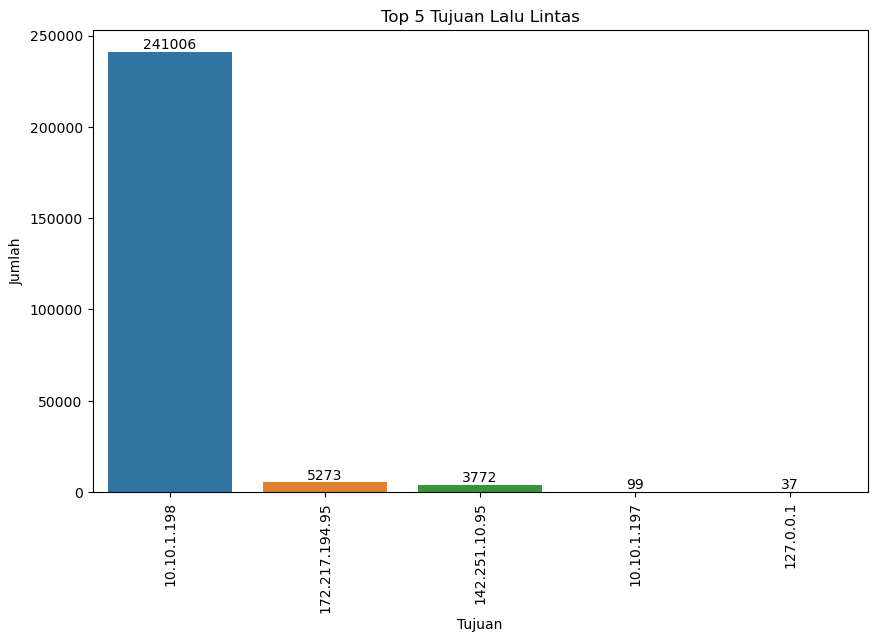

In [8]:
# Visualisasi top 5 tujuan dengan bar plot
top_destinations = df['Destination'].value_counts().head(5)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_destinations.index, y=top_destinations.values)
plt.title('Top 5 Tujuan Lalu Lintas')
plt.xlabel('Tujuan')
plt.ylabel('Jumlah')
# Tambahkan jumlah di atas tiap bar
for index, value in enumerate(top_destinations.values):
    plt.text(index, value, str(value), ha='center', va='bottom')
plt.xticks(rotation=90)
plt.show()

# Pre Processing Data

In [9]:
total_entries = df.shape[0]
print("Total jumlah pada dataset:", total_entries)


Total jumlah pada dataset: 250688


In [314]:
df.isnull().sum()

No.              0
Time             0
Source           0
Destination    409
Protocol         0
Length           0
Info             0
dtype: int64

In [10]:
df.duplicated().sum()

0

In [11]:
df=df.dropna(subset=['Destination'])

## Regex

In [14]:

def extract_info_updated(info_string):
    port_matches = re.findall(r'(\d+)\s*>\s*(\d+)', info_string)
    src_port, dst_port = port_matches[0] if port_matches else (None, None)

    ack_type = "TCP Dup ACK" if "TCP Dup ACK" in info_string else "ACK" if "ACK" in info_string else None

    seq_match = re.search(r'Seq=(\d+)', info_string)
    ack_match = re.search(r'Ack=(\d+)', info_string)
    seq_val = int(seq_match.group(1)) if seq_match else None
    ack_val = int(ack_match.group(1)) if ack_match else None

    win_match = re.search(r'Win=(\d+)', info_string)
    len_match = re.search(r'Len=(\d+)', info_string)
    win_val = int(win_match.group(1)) if win_match else None
    len_val = int(len_match.group(1)) if len_match else None

    return src_port, dst_port, ack_type, seq_val, ack_val, win_val, len_val

df['Source Port'], df['Destination Port'], df['ACK Type'], df['Seq Value'], df['Ack Value'], df['Win Value'], df['Len Value'] = zip(*df['Info'].map(extract_info_updated))

df.head()


,No.,Time,Source,Destination,Protocol,Length,Info,Source Port,Destination Port,ACK Type,Seq Value,Ack Value,Win Value,Len Value
0,1,0.000000,172.217.194.95,10.10.1.198,TCP,96,443 > 59620 [ACK] Seq=1 Ack=1 Win=15371 Len=...,443,59620,ACK,1.0,1.0,15371.0,0.0
1,2,0.000000,172.217.194.95,10.10.1.198,TCP,96,[TCP Dup ACK 1#1] 443 > 59620 [ACK] Seq=1 Ac...,443,59620,TCP Dup ACK,1.0,1.0,15371.0,0.0
2,3,0.000000,172.217.194.95,10.10.1.198,TCP,96,[TCP Dup ACK 1#2] 443 > 59620 [ACK] Seq=1 Ac...,443,59620,TCP Dup ACK,1.0,1.0,15371.0,0.0
3,4,0.000101,172.217.194.95,10.10.1.198,TCP,96,443 > 59620 [ACK] Seq=1 Ack=1401 Win=15371 L...,443,59620,ACK,1.0,1401.0,15371.0,0.0
4,5,0.000101,172.217.194.95,10.10.1.198,TCP,96,[TCP Dup ACK 4#1] 443 > 59620 [ACK] Seq=1 Ac...,443,59620,TCP Dup ACK,1.0,1401.0,15371.0,0.0


In [15]:
descriptive_stats = df.describe()

relevant_columns = ['Length', 'Seq Value', 'Ack Value', 'Win Value', 'Len Value']
descriptive_stats_relevant = descriptive_stats[relevant_columns]

descriptive_stats_relevant


,Length,Seq Value,Ack Value,Win Value,Len Value
count,250279.000000,2.414160e+05,2.414110e+05,2.414160e+05,241416.000000
mean,1981.758881,1.838486e+05,1.267878e+08,1.499386e+06,6.686649
std,10552.908815,1.014638e+07,8.126804e+07,1.894610e+06,233.314423
min,56.000000,0.000000e+00,1.000000e+00,4.910000e+02,0.000000
25%,96.000000,5.095000e+03,6.074856e+07,1.537100e+04,0.000000
50%,96.000000,9.263000e+03,1.202608e+08,1.537100e+04,0.000000
75%,96.000000,1.590800e+04,1.783244e+08,3.932416e+06,0.000000
max,64468.000000,4.294967e+09,4.294967e+09,3.932416e+06,64400.000000


In [16]:
df.isnull().sum()

No.                    0
Time                   0
Source                 0
Destination            0
Protocol               0
Length                 0
Info                   0
Source Port         8863
Destination Port    8863
ACK Type            8865
Seq Value           8863
Ack Value           8868
Win Value           8863
Len Value           8863
dtype: int64

In [17]:
mean_seq_value = df['Seq Value'].mean()
df['Seq Value'].fillna(mean_seq_value, inplace=True)

mean_ack_value = df['Ack Value'].mean()
df['Ack Value'].fillna(mean_ack_value, inplace=True)

mean_win_value = df['Win Value'].mean()
df['Win Value'].fillna(mean_win_value, inplace=True)

mean_len_value = df['Len Value'].mean()
df['Len Value'].fillna(mean_len_value, inplace=True)


In [20]:
df.dropna(subset=['Source Port'], inplace=True)
df.dropna(subset=['Destination Port'], inplace=True)
df.dropna(subset=['ACK Type'], inplace=True)

In [21]:
df.isnull().sum()

No.                 0
Time                0
Source              0
Destination         0
Protocol            0
Length              0
Info                0
Source Port         0
Destination Port    0
ACK Type            0
Seq Value           0
Ack Value           0
Win Value           0
Len Value           0
dtype: int64

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 241412 entries, 0 to 250686
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   No.               241412 non-null  int64  
 1   Time              241412 non-null  float64
 2   Source            241412 non-null  object 
 3   Destination       241412 non-null  object 
 4   Protocol          241412 non-null  object 
 5   Length            241412 non-null  int64  
 6   Info              241412 non-null  object 
 7   Source Port       241412 non-null  object 
 8   Destination Port  241412 non-null  object 
 9   ACK Type          241412 non-null  object 
 10  Seq Value         241412 non-null  float64
 11  Ack Value         241412 non-null  float64
 12  Win Value         241412 non-null  float64
 13  Len Value         241412 non-null  float64
dtypes: float64(5), int64(2), object(7)
memory usage: 27.6+ MB


## Seleksi Fitur

In [24]:
X = df[['Time', 'Length', 'Source Port', 'Destination Port', 'Seq Value', 'Ack Value', 'Win Value', 'Len Value']]
y = df['ACK Type']

In [25]:
numeric_columns = ['Time', 'Length', 'Seq Value', 'Ack Value', 'Win Value', 'Len Value']
categorical_columns = ['Source Port', 'Destination Port']

In [26]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])

In [27]:
X_processed = preprocessor.fit_transform(X)

# Membagi Data menjadi Train, Val, dan Test

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Membangun Model

In [30]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

c:\Users\ichaa\anaconda3\envs\bigdata\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [31]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [32]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

RandomForestClassifier()

In [33]:
svm_model = SVC()
svm_model.fit(X_train, y_train)

SVC()

# Evaluasi

In [38]:
models = [log_reg, decision_tree, random_forest, svm_model]
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM']
accuracies = {}

for model, name in zip(models, model_names):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies[name] = accuracy
    print(f"Model: {name}")
    print("Accuracy:", accuracy)
    print(classification_report(y_test, y_pred))

Model: Logistic Regression
Accuracy: 0.7228009858542344
              precision    recall  f1-score   support

         ACK       0.90      0.04      0.07     13836
 TCP Dup ACK       0.72      1.00      0.84     34447

    accuracy                           0.72     48283
   macro avg       0.81      0.52      0.45     48283
weighted avg       0.77      0.72      0.62     48283

Model: Decision Tree
Accuracy: 0.5756270322887973
              precision    recall  f1-score   support

         ACK       0.24      0.23      0.23     13836
 TCP Dup ACK       0.70      0.72      0.71     34447

    accuracy                           0.58     48283
   macro avg       0.47      0.47      0.47     48283
weighted avg       0.57      0.58      0.57     48283

Model: Random Forest
Accuracy: 0.638485595344117
              precision    recall  f1-score   support

         ACK       0.29      0.18      0.23     13836
 TCP Dup ACK       0.71      0.82      0.76     34447

    accuracy               

In [39]:
print("Accuracy :")
for name in model_names:
    print(f"{name}: {accuracies[name]}")

Accuracy :
Logistic Regression: 0.7228009858542344
Decision Tree: 0.5756270322887973
Random Forest: 0.638485595344117
SVM: 0.7209991094173933


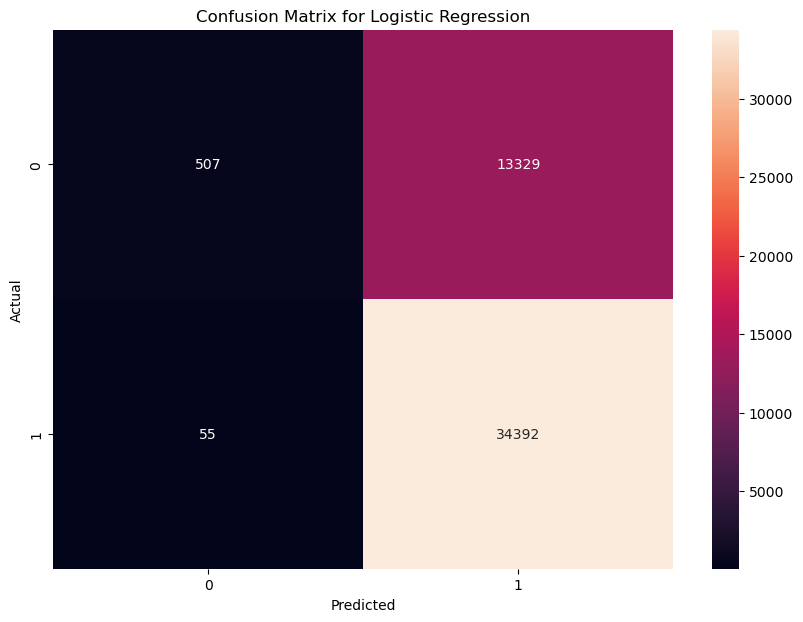

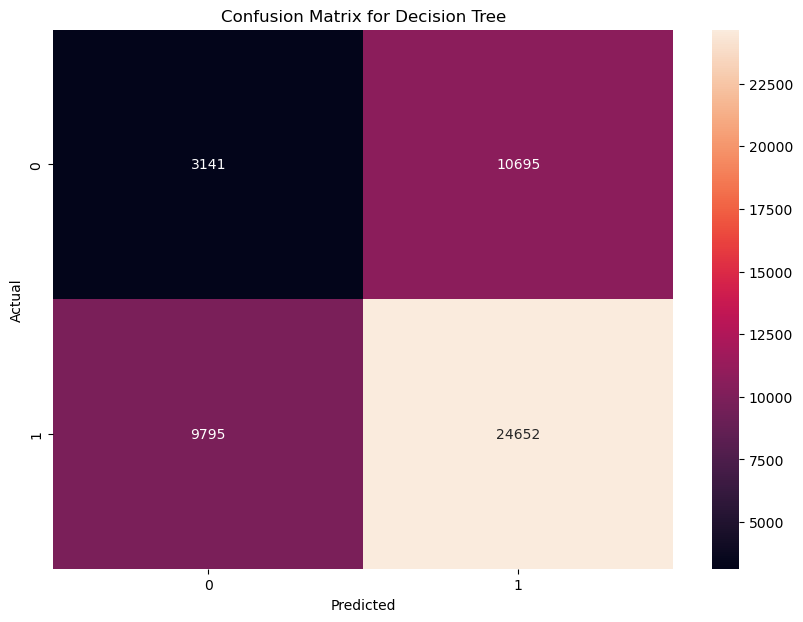

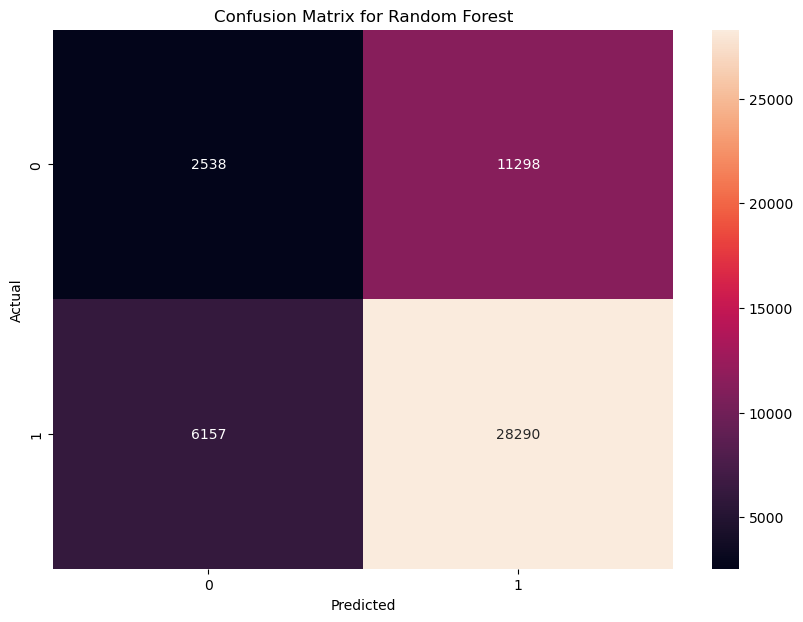

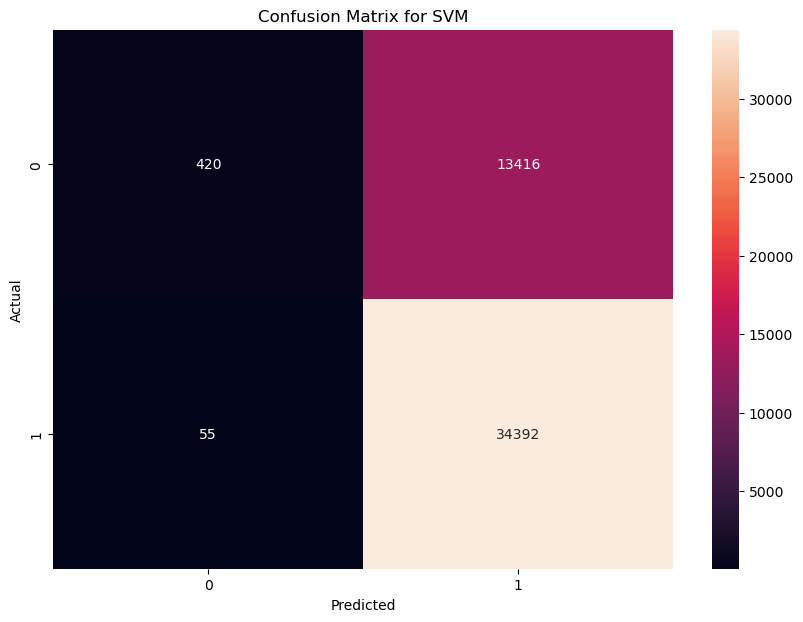

In [40]:
models = [log_reg, decision_tree, random_forest, svm_model]
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM']

for model, name in zip(models, model_names):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    # Menampilkan confusion matrix menggunakan seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()